In [6]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf

In [5]:
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))

TensorFlow version: 2.3.1
Eager execution: True


In [7]:
train_dataset_url = "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv"
train_dataset_fp = tf.keras.utils.get_file(fname=os.path.basename(train_dataset_url), origin=train_dataset_url)
print("Local copy of the dataset file: {}".format(train_dataset_fp))

8192/2194 [================================================================================================================] - 0s 0us/step
Local copy of the dataset file: /home/haruiz/.keras/datasets/iris_training.csv


In [10]:
!head -n5 {train_dataset_fp}

120,4,setosa,versicolor,virginica
6.4,2.8,5.6,2.2,2
5.0,2.3,3.3,1.0,1
4.9,2.5,4.5,1.7,2
4.9,3.1,1.5,0.1,0


In [11]:
# column order in CSV file
column_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
feature_names = column_names[:-1]
label_name = column_names[-1]
print("Features: {}".format(feature_names))
print("Label: {}".format(label_name))

Features: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Label: species


In [12]:
class_names = ['Iris setosa', 'Iris versicolor', 'Iris virginica']

In [27]:
batch_size = 32
train_dataset = tf.data.experimental.make_csv_dataset(
    train_dataset_fp,
    batch_size,
    column_names=column_names,
    label_name=label_name,
    num_epochs=1)

In [28]:
features, labels = next(iter(train_dataset))
print(features)

OrderedDict([('sepal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([6.4, 4.8, 5.9, 5. , 7.2, 5.1, 4.6, 6.5, 6.1, 6. , 4.6, 4.9, 6.4,
       4.8, 7.9, 5.7, 5.8, 4.9, 4.4, 5. , 4.9, 5.7, 5. , 5. , 6.5, 6.8,
       5.7, 6.3, 6.6, 4.7, 5.6, 5.7], dtype=float32)>), ('sepal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([3.2, 3.1, 3.2, 3.4, 3. , 3.5, 3.4, 3.2, 2.6, 2.7, 3.6, 3.1, 2.7,
       3. , 3.8, 4.4, 2.7, 3.1, 3.2, 3. , 2.4, 2.9, 3.4, 2. , 2.8, 3. ,
       2.8, 2.7, 2.9, 3.2, 2.7, 3. ], dtype=float32)>), ('petal_length', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([4.5, 1.6, 4.8, 1.5, 5.8, 1.4, 1.4, 5.1, 5.6, 5.1, 1. , 1.5, 5.3,
       1.4, 6.4, 1.5, 5.1, 1.5, 1.3, 1.6, 3.3, 4.2, 1.6, 3.5, 4.6, 5.5,
       4.5, 4.9, 4.6, 1.3, 4.2, 4.2], dtype=float32)>), ('petal_width', <tf.Tensor: shape=(32,), dtype=float32, numpy=
array([1.5, 0.2, 1.8, 0.2, 1.6, 0.3, 0.3, 2. , 1.4, 1.6, 0.2, 0.1, 1.9,
       0.1, 2. , 0.4, 1.9, 0.1, 0.2, 0.2, 1. , 1.3, 0.4, 1. ,

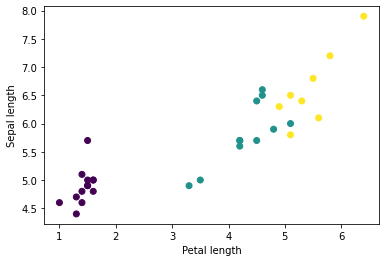

In [29]:
plt.scatter(features['petal_length'],
            features['sepal_length'],
            c=labels,
            cmap='viridis')
plt.xlabel("Petal length")
plt.ylabel("Sepal length")
plt.show()

In [30]:
def pack_features_vector(features, labels):
    """Pack the features into a single array."""
    features = tf.stack(list(features.values()), axis=1)
    return features, labels

In [31]:
train_dataset = train_dataset.map(pack_features_vector)

In [32]:
features, labels = next(iter(train_dataset))
print(features[:5])

tf.Tensor(
[[6.5 3.2 5.1 2. ]
 [5.3 3.7 1.5 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.4 1.6 0.4]
 [6.1 2.6 5.6 1.4]], shape=(5, 4), dtype=float32)


In [33]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)),  # input shape required
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(3)
])

In [34]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[-0.85580736, -0.11141788, -0.12125983],
       [-0.8813087 , -0.14400718, -0.35099778],
       [-0.78104174, -0.13252819, -0.23525693],
       [-0.8892771 , -0.13319364, -0.28246537],
       [-0.5786788 , -0.074863  , -0.00661046]], dtype=float32)>

In [46]:
result = tf.nn.softmax(predictions[:5]).numpy()
print(result)

[[0.19268958 0.4056416  0.40166885]
 [0.20877926 0.4364086  0.3548121 ]
 [0.21557958 0.41233814 0.37208226]
 [0.20143051 0.42903048 0.369539  ]
 [0.225889   0.37385184 0.4002591 ]]


In [47]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [48]:
def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)
    return loss_object(y_true=y, y_pred=y_)

l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.109252691268921


In [49]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, training=True)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [50]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [52]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {}, Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(model, features, labels, training=True).numpy()))

Step: 1, Initial Loss: 1.089958667755127
Step: 2, Loss: 1.0727622509002686


In [53]:
## Note: Rerunning this cell uses the same model variables

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in train_dataset:
    # Optimize the model
        loss_value, grads = grad(model, x, y)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))

        # End epoch
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())

        if epoch % 50 == 0:
            print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))

Epoch 000: Loss: 1.032, Accuracy: 53.125%
Epoch 000: Loss: 1.124, Accuracy: 35.938%
Epoch 000: Loss: 1.118, Accuracy: 35.417%
Epoch 000: Loss: 1.097, Accuracy: 35.000%
Epoch 050: Loss: 0.428, Accuracy: 84.375%
Epoch 050: Loss: 0.372, Accuracy: 85.938%
Epoch 050: Loss: 0.390, Accuracy: 86.458%
Epoch 050: Loss: 0.404, Accuracy: 85.000%
Epoch 100: Loss: 0.249, Accuracy: 96.875%
Epoch 100: Loss: 0.235, Accuracy: 95.312%
Epoch 100: Loss: 0.265, Accuracy: 95.833%
Epoch 100: Loss: 0.262, Accuracy: 96.667%
Epoch 150: Loss: 0.157, Accuracy: 100.000%
Epoch 150: Loss: 0.201, Accuracy: 96.875%
Epoch 150: Loss: 0.180, Accuracy: 97.917%
Epoch 150: Loss: 0.185, Accuracy: 98.333%
Epoch 200: Loss: 0.180, Accuracy: 96.875%
Epoch 200: Loss: 0.153, Accuracy: 98.438%
Epoch 200: Loss: 0.144, Accuracy: 97.917%
Epoch 200: Loss: 0.138, Accuracy: 97.500%


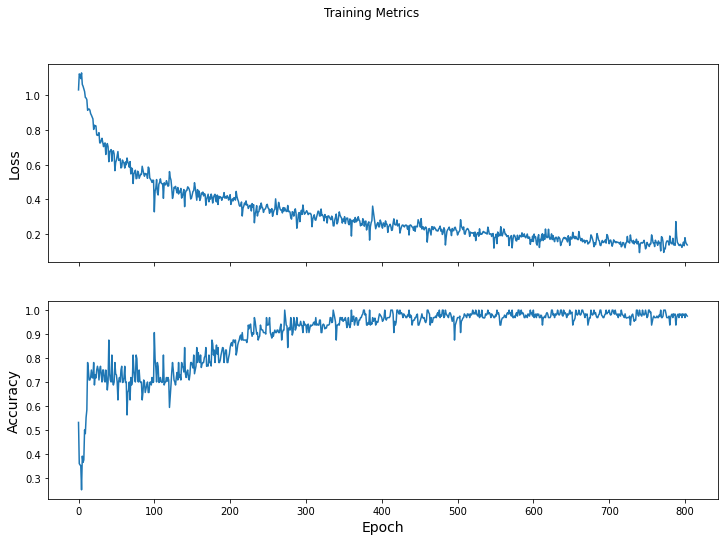

In [54]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()